# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [22]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller, arma_order_select_ic
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from catboost import CatBoostRegressor, Pool

In [23]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [24]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()
display(data.head(10))
display(data.info())
display(data.describe())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [25]:
data.isna().sum()

num_orders    0
dtype: int64

In [26]:
data.duplicated().sum()

4165

It's not unexpected that duplicate values would be present across the num_orders column.

<AxesSubplot:xlabel='datetime'>

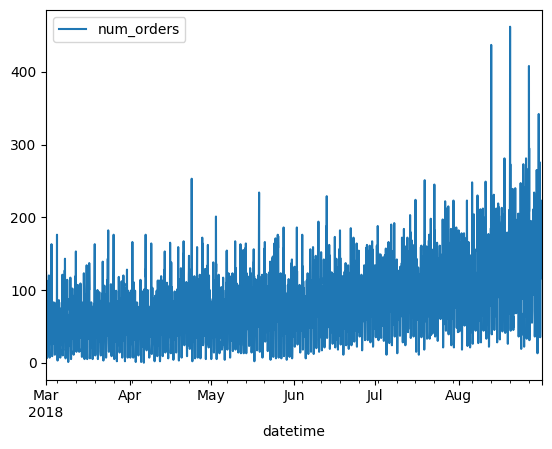

In [27]:
data.plot()

<AxesSubplot:xlabel='datetime'>

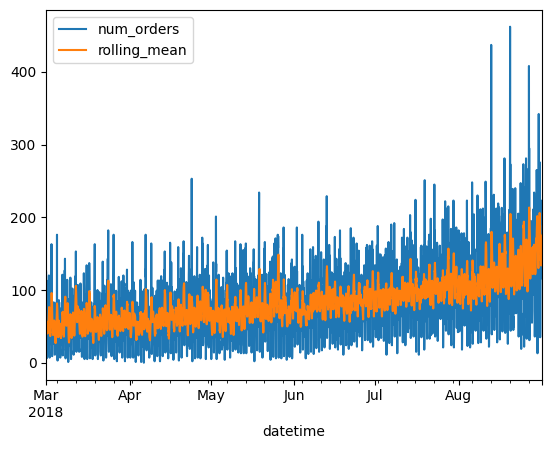

In [28]:
data['rolling_mean'] = data.rolling(10).mean()
data.plot()

## Analysis

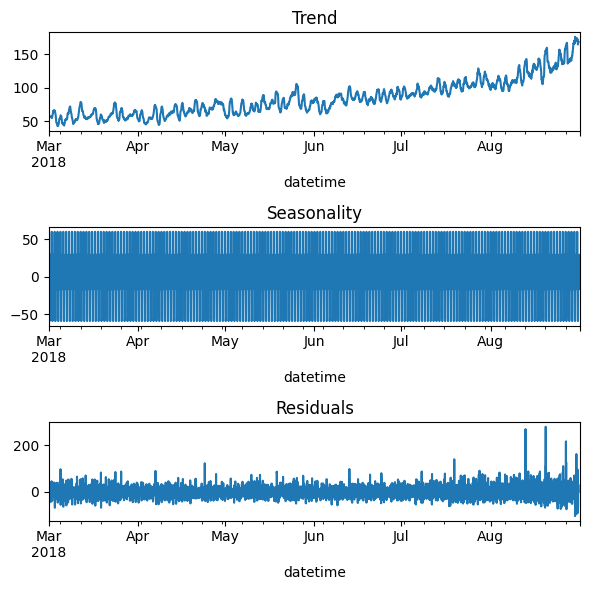

In [29]:
data = data.fillna(method='bfill')

decomposed = seasonal_decompose(data['num_orders'], period = 24)

plt.figure(figsize=(6, 6))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

The trend graph shows that taxi orders are increasing as time goes on.
The seasonality graph indicates that there is a clear periodic pattern, specific spikes throughout the day or week. This data will be most beneficial to predicting future data.
The residuals graph shows there are periods of unexpected demands, especially towards the end of summer and into the fall.

In [30]:
# verify correctness of decomposed data compared to original data
print(decomposed.trend[100:105]+decomposed.seasonal[100:105]+decomposed.resid[100:105])
print()
print(data[100:105])

datetime
2018-03-05 04:00:00    34.0
2018-03-05 05:00:00    16.0
2018-03-05 06:00:00     3.0
2018-03-05 07:00:00    14.0
2018-03-05 08:00:00    31.0
Freq: H, dtype: float64

                     num_orders  rolling_mean
datetime                                     
2018-03-05 04:00:00          34          73.8
2018-03-05 05:00:00          16          69.8
2018-03-05 06:00:00           3          62.4
2018-03-05 07:00:00          14          56.3
2018-03-05 08:00:00          31          51.1


P-value: 1.095877674651026e-28


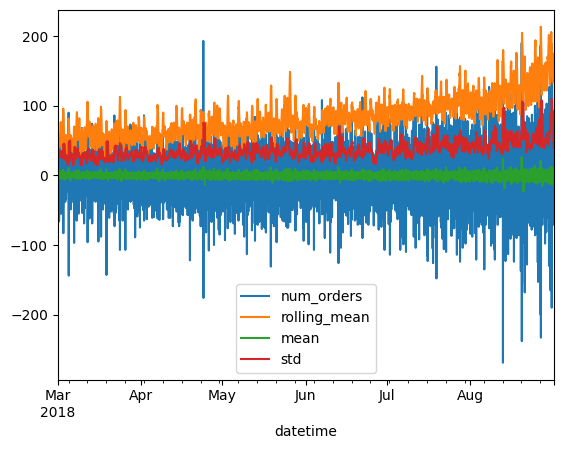

In [31]:
# perform time series difference
data['num_orders'] -= data['num_orders'].shift()

# checking if data is stationary

data['mean'] = data['num_orders'].rolling(15).mean()
data['std'] = data['num_orders'].rolling(15).std()
data.plot()

data_stationarityTest = adfuller(data['num_orders'].dropna())
print("P-value:", data_stationarityTest[1])

Based on the P-value (< 0.05) and the graph (distribution isn't changing much overtime), the data is likely stationary.

## Training

In [32]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = (data['num_orders'].shift().rolling(rolling_mean_size).mean())

    

make_features(data,5, 5)
print(data.head(10))

                     num_orders  rolling_mean  mean  std  year  month  day  \
datetime                                                                     
2018-03-01 00:00:00         NaN           NaN   NaN  NaN  2018      3    1   
2018-03-01 01:00:00       -39.0           NaN   NaN  NaN  2018      3    1   
2018-03-01 02:00:00       -14.0           NaN   NaN  NaN  2018      3    1   
2018-03-01 03:00:00        -5.0           NaN   NaN  NaN  2018      3    1   
2018-03-01 04:00:00       -23.0           NaN   NaN  NaN  2018      3    1   
2018-03-01 05:00:00       -37.0           NaN   NaN  NaN  2018      3    1   
2018-03-01 06:00:00         6.0         -23.6   NaN  NaN  2018      3    1   
2018-03-01 07:00:00         3.0         -14.6   NaN  NaN  2018      3    1   
2018-03-01 08:00:00        19.0         -11.2   NaN  NaN  2018      3    1   
2018-03-01 09:00:00        35.0          -6.4   NaN  NaN  2018      3    1   

                     dayofweek  hour  lag_1  lag_2  lag_3  lag_

In [33]:
data = data.dropna()
features = data.drop(['num_orders'], axis=1)
target = data['num_orders']

features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1)
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)



(3960, 13)
(3960,)
(441, 13)
(441,)


In [34]:
# train linear model
lin_model = LinearRegression()
lin_model.fit(features_train, target_train)
lin_pred_train = lin_model.predict(features_train)

print('RMSE for the Linear Regression training set:', np.sqrt(mean_squared_error(target_train, lin_pred_train))) 

RMSE for the Linear Regression training set: 27.053386554690768


In [35]:
final_lin_model = lin_model.predict(features_test)
print('RMSE for the Linear Regression test set:', np.sqrt(mean_squared_error(target_test, final_lin_model)))

RMSE for the Linear Regression test set: 45.487739326592575


In [36]:
# Split the data into train and test by time (90% for training and 10% for testing)
train_size = int(len(data) * 0.9)
train, test = data[:train_size], data[train_size:]

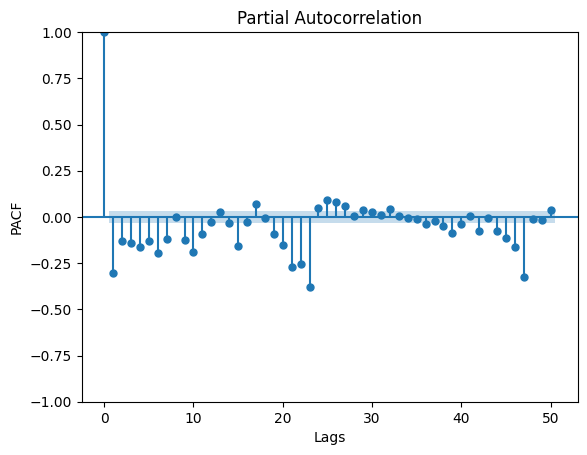

In [37]:
# AR model
lags_to_check = 50 
acf = plot_pacf(x=train['num_orders'], lags=lags_to_check)
plt.xlabel("Lags")
plt.ylabel("PACF")
plt.show()

The 3rd lags falls within the confidence interval, therefore, we stop counting at 7.

In [38]:
# double checking with automated function
mod = ar_select_order(endog=train['num_orders'], maxlag=50)
ar_order = mod.ar_lags
print('Lags that define the AR model order', ar_order)

Lags that define the AR model order [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


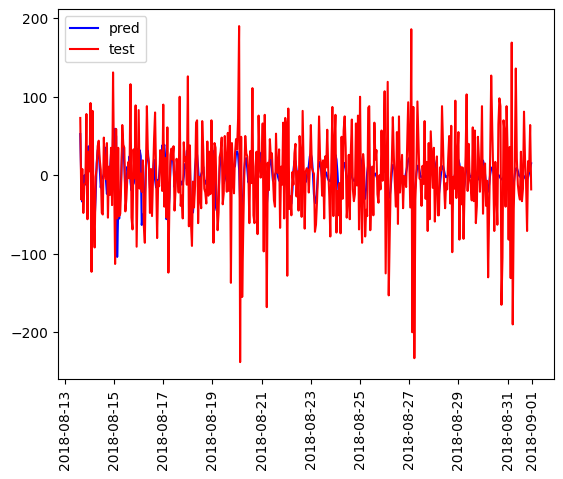

RMSE of AR Model: 55.55043793001354


In [39]:
# AR model 
ar_model = AutoReg(train['num_orders'], lags=ar_order)
ar_model = ar_model.fit()
ar_pred = ar_model.predict(start=len(train['num_orders']), end=len(train['num_orders']) + len(test['num_orders']) - 1)

plt.plot(ar_pred, color='blue', label='pred')
plt.plot(test['num_orders'], color='red', label='test')
plt.legend(loc="upper left")
plt.xticks(rotation=90)
plt.show()

print('RMSE of AR Model:', np.sqrt(mean_squared_error(test['num_orders'], ar_pred)))


/opt/conda/envs/python3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/envs/python3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/envs/python3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Output of the arma_order_select_ic: (0, 9)


/opt/conda/envs/python3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


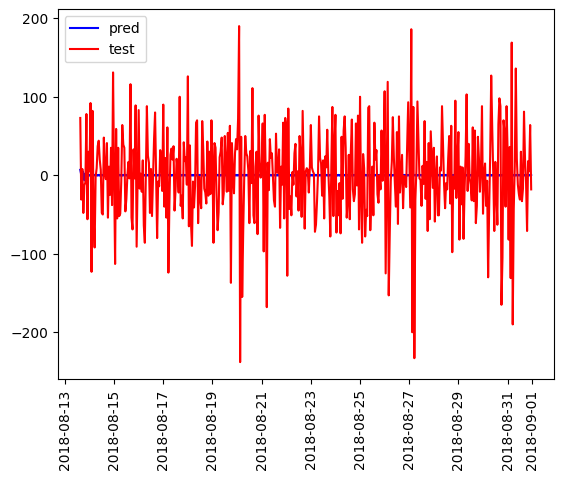

RMSE of MA model: 58.95362437442407


In [40]:
# MA model training
res = arma_order_select_ic(y=train['num_orders'], max_ar=0, max_ma=10)
ma_order = res.bic_min_order[1]
print('Output of the arma_order_select_ic:', res.bic_min_order)

ma_model = ARIMA(train['num_orders'], order=(1, 1, ma_order))
ma_model = ma_model.fit()

ma_pred = ma_model.predict(start=len(train['num_orders']), end=len(train['num_orders']) + len(test['num_orders']) - 1)

plt.plot(ma_pred, color="blue", label="pred")
plt.plot(test['num_orders'], color="red", label="test")
plt.legend(loc="upper left")
plt.xticks(rotation=90)
plt.show()

print('RMSE of MA model:', np.sqrt(mean_squared_error(test['num_orders'], ma_pred)))


In [41]:
# AutoARIMA model
arima_model = auto_arima(train['num_orders'], seasonal=True, scoring='mse', 
                         stepwise=True, trace=True, start_p=0, max_p=3, start_q=0, max_q=3, max_order=5)

predictions = arima_model.predict(len(test['num_orders']))
auto_arima_rmse = np.sqrt(mean_squared_error(test['num_orders'], predictions))
print(f"RMSE on test set using AutoARIMA: {auto_arima_rmse}")

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=39660.201, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=39282.185, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=39121.490, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=39658.201, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.32 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=5.36 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=6.92 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=39119.492, Time=0.42 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.97 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=1.68 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=39280.186, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=2.46 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 21.382 seconds
RMSE on test set using AutoARIMA: 58.89814431816767


In [42]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3960
Model:               SARIMAX(0, 0, 1)   Log Likelihood              -19557.746
Date:                Wed, 02 Apr 2025   AIC                          39119.492
Time:                        02:12:22   BIC                          39132.060
Sample:                    03-01-2018   HQIC                         39123.949
                         - 08-13-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4878      0.010    -46.797      0.000      -0.508      -0.467
sigma2      1140.9993     20.488     55.691      0.000    1100.843    1181.155
===================================================================================
Ljung-Box (L1) (Q):                  34.91   Jarque-Bera (JB):               217.77
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.94   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Conclusion
In conclusion, the models were successfully trained and tested. However, the time series models couldn't achieve an RMSE less than 48. The linear model did achieve an RMSE less than 48.